# Jackknife+ Confidence Intervals on Regressions

On this notebook I will implement the Jackknife+ method to finding confidence intervals on regression predictions. I will also implement other methods from the paper and try to reproduce the results obtained. The idea of having confidence intervals on our models predictions is to best assure the uncertainty on it so we know how much we can trust and act on the predictions.

## Theoretical Introduction

Four main methods are discussed on the paper. One keeps trying to improve over the other: the naive is to optimistic, the jackknife does not work well on degenerated cases and the jackknife+ can be very slow to compute. Of course, the improvement of the confidence interval will always come with a performance drawback.

### Setting Terminology
Let $\hat{q}^+_{n, \alpha}(v_i)$ be the $(1 - \alpha)$ quantile of the distribution $v$ and $\hat{q}^-_{n, \alpha}(v_i)$ be the $\alpha$ quantile. Let also $R_i^{LOO} = |Y_i - \hat{\mu}_{-i}(X_i)|$ be the i-th leave one-out residual.

### Naive

On this method, one trains a model on the entire training set and then calculates the residuals obtained from the training set. Then, for every new prediction point, the CI of that new point is given by the quantile of the distribution of residuals from the training set. So:

$$\hat{\mu}(x_{i+1}) \pm (1 - \alpha) \text{ quantile of} R(\hat{\mu})$$

We can rewrite it as follows:

$$\hat{C}^{\text{naive}}_{n, \alpha} (X_{n+1}) = \hat{\mu}(x_{i+1}) \pm \hat{q}^+_{n, \alpha}(|Y_i - \hat{\mu}(X_i)|)$$

The problem with this methodology is that if the model overfits, the residuals will become close to zero and therefore the confidence interval will go to zero. Even if the residuals are not zero, this method still very optimistic, as we know that the error on the training set will (almost) always be smaller than the one on the test set.

### Jackknife

For the jackknife method, we compute $n$ models using the leave-one-out method. For each one, we compute the residual of the leaved out sample and then we aggregate the residuals into a distribution. After that, we train a regression on the entire training set and use it to predict the center point of the new test point. Then, the CI is given by the quantile of the distribution of the residuals from the leave-one-out:

$$\hat{\mu}(x_{i+1}) \pm (1 - \alpha) \text{ quantile of} R(\hat{\mu}_{-1})$$

We can then write:

$$\hat{C}^{\text{jackknife}}_{n, \alpha} (X_{n+1}) = \hat{\mu}(x_{i+1}) \pm \hat{q}^+_{n, \alpha}(R_i^{LOO})$$

This aims to solve the problem from the previous method since now we are looking at a distribution of residuals from a test sample. Notice, however, that this requires fitting $n$ models, one for each sample of our dataset, which cannot be feasible.

When the regression becomes unstable, such as on the scenario where the number of dimensions is close to the number of samples, this method loses its coverage. However, this seems to be a really rare corner case.

### Jackknife+

The jackknife+ tries to solve the instability of the jackknife on that corner case by using every regressor fit on the leave-one-out instead of a regressor fitted on the entire training set. The idea is that, when using the Jackknife method, the $\hat{\mu}$ regressor has always seem one more training point than the the models on the residuals, which makes it not directly comparable to the residuals. Therefore, one can write the Jackknife+ interval as follows:

$$\hat{C}^{\text{jackknife+}}_{n, \alpha} (X_{n+1}) = \hat{\mu_{-i}}(x_{i+1}) \pm \hat{q}^+_{n, \alpha}(R_i^{LOO})$$

The basic idea here is that, when defining the upper and lower bounds for a given instance, we use the median predict of all the models on that instance to find the prediction point, and then we use the residuals quantiles to define the interval as usual.

### CV+

The CV+ is the application of the Jackknife+ method but using a K-Fold Cross Validation instead of a leave-one-out methodology. This method is best suited when $n$ is too large making the use of a leave one out approach unfeasible.

## Implementation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from mapie.regression import MapieRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold

In [2]:
X, y = load_boston(return_X_y=True)

In [3]:
alpha = 0.95

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [5]:
def generate_results_dataset(predictions, ci):
    df = pd.DataFrame()
    df['prediction'] = preds
    if ci >= 0:
        df['upper'] = preds + ci
        df['lower'] = preds - ci
    else:
        df['upper'] = preds - ci
        df['lower'] = preds + ci
        
    return df

In [6]:
def generate_plot(y_test, preds, ci, positive=True):
    
    if ci < 0:
        ci_pack = np.vstack([preds + ci, preds - ci])
    else:
        ci_pack = np.vstack([preds + ci, preds - ci])
    
    plt.figure(figsize=(12,9))
    plt.errorbar([i for i in range(len(preds))], preds, ci_pack, fmt='o', color='black', ecolor='lightgray')
    plt.plot([i for i in range(len(y_test))], y_test, 'o', c='r')
    plt.legend(['True Value', 'Prediction', 'Confidence Interval'])
    plt.show()

In [7]:
def generate_plot_plus(y_test, preds, bottom, upper,):
    
    ci_pack = np.vstack([bottom, upper])
    
    plt.figure(figsize=(12,9))
    plt.errorbar([i for i in range(len(preds))], preds, ci_pack, fmt='o', color='black', ecolor='lightgray')
    plt.plot([i for i in range(len(y_test))], y_test, 'o', c='r')
    plt.legend(['True Value', 'Prediction', 'Confidence Interval'])
    plt.show()

### Naive Approach

In [8]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

residuals = y_train - rf.predict(X_train)

In [9]:
ci = np.quantile(residuals, 1 - alpha)
preds = rf.predict(X_test)

In [10]:
df = generate_results_dataset(preds, ci)
df.head()

,prediction,upper,lower
0,22.635,24.4612,20.8088
1,30.516,32.3422,28.6898
2,16.014,17.8402,14.1878
3,22.718,24.5442,20.8918
4,16.335,18.1612,14.5088


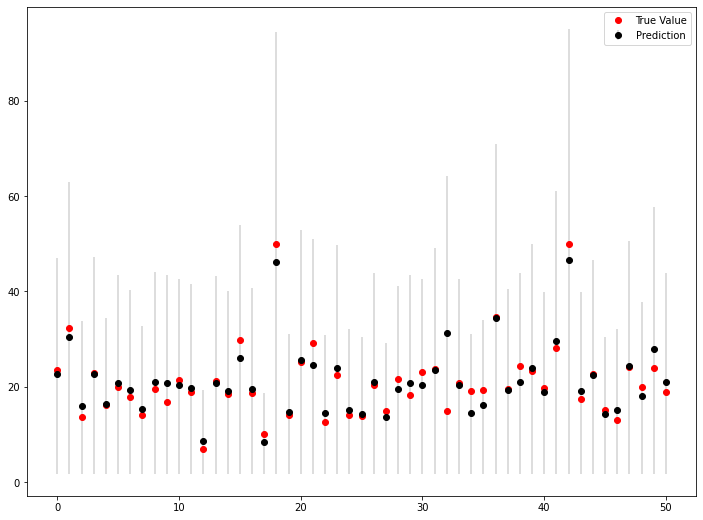

In [11]:
generate_plot(y_test, preds, ci, positive=ci>0)

### Jackknife

In [12]:
kf = KFold(n_splits=len(y_train)-1, shuffle=True, random_state=42)
res = []
for train_index, test_index in kf.split(X_train):
    X_train_, X_test_ = X_train[train_index], X_train[test_index]
    y_train_, y_test_ = y_train[train_index], y_train[test_index]
    
    rf.fit(X_train_, y_train_)
    res.extend(list(y_test_ - rf.predict(X_test_)))

In [13]:
rf.fit(X_train, y_train)
ci = np.quantile(res, 1 - alpha)

In [14]:
preds = rf.predict(X_test)
df = generate_results_dataset(preds, ci)

In [15]:
df.head()

,prediction,upper,lower
0,22.635,27.3628,17.9072
1,30.516,35.2438,25.7882
2,16.014,20.7418,11.2862
3,22.718,27.4458,17.9902
4,16.335,21.0628,11.6072


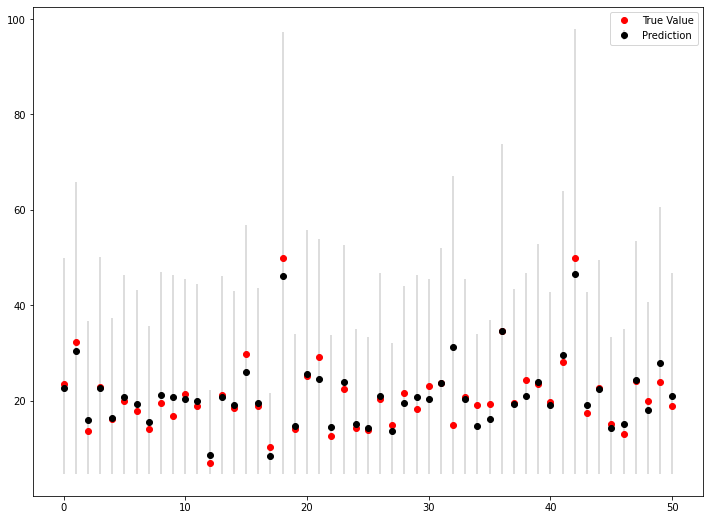

In [16]:
generate_plot(y_test, preds, ci, positive=ci>0)

### Jackknife+

In [17]:
kf = KFold(n_splits=len(y_train)-1, shuffle=True, random_state=42)
res = []
estimators = []
for train_index, test_index in kf.split(X_train):
    X_train_, X_test_ = X_train[train_index], X_train[test_index]
    y_train_, y_test_ = y_train[train_index], y_train[test_index]
    
    rf.fit(X_train_, y_train_)
    estimators.append(rf)
    res.extend(list(y_test_ - rf.predict(X_test_)))

In [18]:
y_pred_multi = np.column_stack([e.predict(X_test) for e in estimators])
y_pred_multi.shape

(51, 454)

In [19]:
ci = np.quantile(res, 1 - alpha)
top = []
bottom = []

for i in range(y_pred_multi.shape[0]):
    if ci > 0:
        top.append(np.quantile(y_pred_multi[i] + ci, 1 - alpha))
        bottom.append(np.quantile(y_pred_multi[i] - ci, 1 - alpha))
    else:
        top.append(np.quantile(y_pred_multi[i] - ci, 1 - alpha))
        bottom.append(np.quantile(y_pred_multi[i] + ci, 1 - alpha))     

In [20]:
preds = np.median(y_pred_multi, axis=1)
df = pd.DataFrame()
df['pred'] = preds
df['upper'] = top
df['lower'] = bottom

In [21]:
df.head()

,pred,upper,lower
0,22.792,27.5198,18.0642
1,30.760,35.4878,26.0322
2,15.557,20.2848,10.8292
3,23.382,28.1098,18.6542
4,16.447,21.1748,11.7192


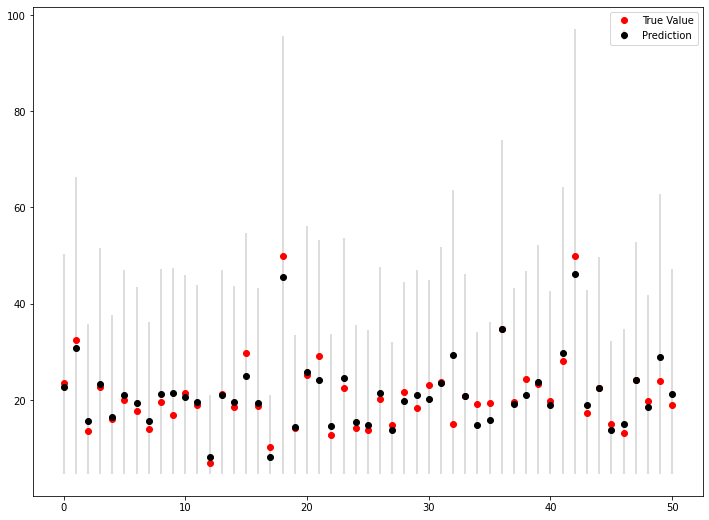

In [22]:
generate_plot_plus(y_test, preds, bottom, top)

### CV+

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
res = []
estimators = []
for train_index, test_index in kf.split(X_train):
    X_train_, X_test_ = X_train[train_index], X_train[test_index]
    y_train_, y_test_ = y_train[train_index], y_train[test_index]
    
    rf.fit(X_train_, y_train_)
    estimators.append(rf)
    res.extend(list(y_test_ - rf.predict(X_test_)))

In [24]:
y_pred_multi = np.column_stack([e.predict(X_test) for e in estimators])
y_pred_multi.shape

(51, 5)

In [25]:
ci = np.quantile(res, 1 - alpha)
top = []
bottom = []

for i in range(y_pred_multi.shape[0]):
    if ci > 0:
        top.append(np.quantile(y_pred_multi[i] + ci, 1 - alpha))
        bottom.append(np.quantile(y_pred_multi[i] - ci, 1 - alpha))
    else:
        top.append(np.quantile(y_pred_multi[i] - ci, 1 - alpha))
        bottom.append(np.quantile(y_pred_multi[i] + ci, 1 - alpha))  

In [26]:
preds = np.median(y_pred_multi, axis=1)
df = pd.DataFrame()
df['pred'] = preds
df['upper'] = top
df['lower'] = bottom

In [27]:
df.head()

,pred,upper,lower
0,23.913,28.5879,19.2381
1,30.807,35.4819,26.1321
2,15.822,20.4969,11.1471
3,22.779,27.4539,18.1041
4,17.252,21.9269,12.5771


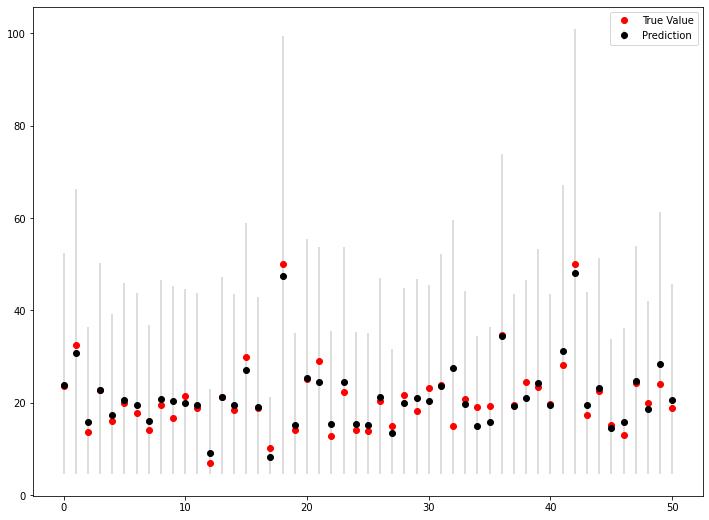

In [28]:
generate_plot_plus(y_test, preds, bottom, top)

In [29]:
alpha = [0.05]
mapie = MapieRegressor(rf, method="naive")
mapie.fit(X_train, y_train)
y_pred, y_pis = mapie.predict(X_test, alpha=alpha)

In [30]:
alpha = [0.05]
mapie = MapieRegressor(rf, method="plus")
mapie.fit(X_train, y_train)
y_pred, y_pis = mapie.predict(X_test, alpha=alpha)